In [2]:
include("../sensor.jl") # To retrieve Sensor Positions
include("../doa/cbf.jl") # Conventional Beamformer
include("../doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("../doa/music.jl") # MUSIC

include("../utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [3]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

include("../signal_generator/generate_sig.jl")
az_gt = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;
c0 = 343;          # Speed of Medium (in m/s)

sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, az_gt, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, az_gt2, c0); 
new_sig = sig1 + sig2;

Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.251750 seconds (42.34 k allocations: 129.118 MiB, 11.05% gc time, 17.76% compilation time)
Now Generated Signal has size: (320000, 8)
Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.327813 seconds (287 allocations: 126.970 MiB, 49.17% gc time)
Now Generated Signal has size: (320000, 8)


In [4]:
#= 
Step 1: Pre-process Signal by selecting 
        Frequency of Interest at each channel
        (FFT instead of STFT)
=#
function filter_freq_per_ch(new_sig, freq_interest)
    # freq_interest = freq; # (Hz)
        new_S = []
        NFFT = size(new_sig, 1);
        frequencies = sample_rate/NFFT*(0:(NFFT-1));
        (_, freq_idx) = findmin( abs.(frequencies .- freq_interest) );
    
        for signal in eachcol(new_sig)
            S_interest = fft(signal);
            S_interest = S_interest[freq_idx];
            push!(new_S, S_interest);
        end
        return new_S
    end
    
    new_S = filter_freq_per_ch(new_sig, freq);
    new_S1 = filter_freq_per_ch(sig1, freq);
    new_S2 = filter_freq_per_ch(sig2, freq);

    Rx = (1 ./ 1) .* new_S * new_S';
    Rx1 = (1 ./ 1) .* new_S1 * new_S1';
    Rx2 = (1 ./ 1) .* new_S2 * new_S2';

In [5]:
# Create Measurement Matrix A
az_list = -180:1:180;
num_sensors = length(sensors);
A = Matrix{ComplexF64}(undef, num_sensors, length(az_list))
for (sensor_idx, sensor) in enumerate(sensors)
    for (az_idx, az) in enumerate(az_list)
        A[sensor_idx, az_idx] = vandermonde_weight(sensor, az, 90, freq, c0);
    end
end

In [6]:
function sortk(array::Vector, k::Int, descending::Bool=true)
    idx = sortperm(array);
    descending ? idx = reverse!(idx) : idx = idx;
    return array[idx[1:k]], idx[1:k]
end

using FindPeaks1D
#=
Input:
array       : Unsorted Vector containing values
k           : Number of maximum values

Output:
peak_values : Vector containing Peak values
peak_idx    : Indices of the Peak Values from original array
=#
function find_peaks_k(array::Vector, k::Int)
    pkindices, properties = findpeaks1d(array);
    peak_values, peak_idx = sortk(array, k);
    return peak_values, peak_idx
end

find_peaks_k (generic function with 1 method)

In [7]:
rank(Rx)

1

In [8]:
size(new_S)
size(new_sig)

(320000, 8)

In [9]:
initial_x = abs.(pinv(A) * new_S)
time_x = abs.(pinv(A) * new_sig[1, :])
cbf_x, ___ = cbf(Rx, sensors, freq, c0)

([6.542226883427856e10, 6.542243962857988e10, 6.542259886997621e10, 6.542274651019311e10, 6.5422882504473885e10, 6.542300681159307e10, 6.542311939386866e10, 6.542322021717339e10, 6.542330925094494e10, 6.5423386468195e10  …  6.5420221491087036e10, 6.542049351671023e10, 6.542075457947628e10, 6.542100460022428e10, 6.542124350314398e10, 6.54214712157985e10, 6.542168766914598e10, 6.5421892797560165e10, 6.542208653885006e10, 6.542226883427856e10], LinRange{Float64}(-180.0, 180.0, 361))

In [10]:
function normalize_P(P, az_list) 
    (P_max, max_idx) = findmax(P);
    return (P ./ P_max), az_list[max_idx]
end

sqInv_x, az_sqInv_x = normalize_P(initial_x.^2, az_list);
time_x, az_time_x = normalize_P(time_x, az_list)
cbf_norm_x, az_cbf_x = normalize_P(cbf_x, az_list)

([0.9999796444822878, 0.9999822550738763, 0.9999846890792651, 0.9999869457605791, 0.9999890244337124, 0.9999909244685333, 0.9999926452890724, 0.9999941863736941, 0.9999955472552533, 0.9999967275212337  …  0.9999483508333015, 0.9999525087460552, 0.9999564990914932, 0.9999603206596405, 0.9999639722917371, 0.999967452880585, 0.9999707613708791, 0.999973896759522, 0.9999768580959238, 0.9999796444822878], -165)

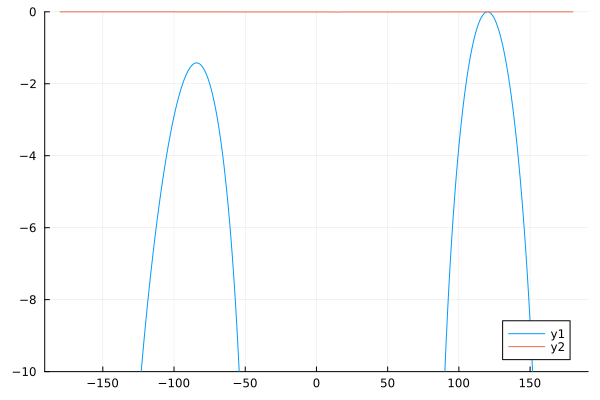

In [11]:
using Plots
plot(az_list, pow2db.(sqInv_x))
plot!(az_list, pow2db.(cbf_norm_x))
# plot!(az_list, pow2db.(time_x))
ylims!((-10, 0))

In [12]:
using LinearAlgebra
rank(A)
svd(A)

SVD{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
U factor:
8×8 Matrix{ComplexF64}:
 -0.353554-1.79195e-23im   0.191347-1.83496e-20im  …   0.353553+1.06428e-18im
 -0.353554-3.60821e-5im   -0.191347-1.98127e-5im      -0.353553+1.20894e-13im
 -0.353553-6.15827e-5im   -0.461937-8.06627e-5im       0.353553-5.74575e-13im
 -0.353553-6.15827e-5im   -0.461937-8.06627e-5im      -0.353553+1.09507e-12im
 -0.353554-3.60821e-5im   -0.191347-1.98127e-5im       0.353553-1.37901e-12im
 -0.353554+5.1267e-18im    0.191347-3.75342e-14im  …  -0.353553+1.25978e-12im
 -0.353553+2.55007e-5im    0.461938-3.28321e-5im       0.353553-8.06115e-13im
 -0.353553+2.55007e-5im    0.461938-3.28321e-5im      -0.353553+2.8396e-13im
singular values:
8-element Vector{Float64}:
 53.709059702436875
  1.293375487738315
  1.2898075514272227
  0.01554798967098295
  0.015506034956633523
  0.00012460384852747407
  0.00012426384523024446
  1.0562495295945866e-6
Vt factor:
8×361 Matrix{ComplexF64}:
   -0.0526317+2.6856

In [13]:
using Combinatorics
mse = zeros(size(A, 2), size(A,2));
for (idx1, a1) in enumerate(eachcol(A))
    for (idx2, a2) in enumerate(eachcol(A))
        prototype_A = [a1 a2];
        x = pinv(prototype_A) * new_S;
        mse[idx1, idx2] = norm(new_S - prototype_A * x);
    end
end

In [200]:
minvalue, indices = findmin(mse);
az_list[indices[1]]
az_list[indices[2]]

120

In [215]:
include("../doa/dbf_freeform.jl")
order = 3;
P_dbf, az_list, ___, D = dbf_coFree(Rx, sensors, order, freq, c0)
D = transpose(mapreduce(permutedims, vcat, D))

8×361 transpose(::Matrix{ComplexF64}) with eltype ComplexF64:
   87.424-14250.3im   90.4211-13921.8im  …    87.424-14250.3im
   87.424+14250.3im   84.3205+14539.7im       87.424+14250.3im
 -87.3883-5901.25im  -90.3854-6638.92im     -87.3883-5901.25im
 -87.3883-5901.25im  -84.2848-5147.4im      -87.3883-5901.25im
   87.424+14250.3im   90.4211+13921.8im       87.424+14250.3im
   87.424-14250.3im   84.3205-14539.7im  …    87.424-14250.3im
 -87.3883+5901.25im  -90.3854+6638.92im     -87.3883+5901.25im
 -87.3883+5901.25im  -84.2848+5147.4im      -87.3883+5901.25im

In [226]:
test1, test2 = normalize_P(P_dbf, az_list)
test1

361-element Vector{Float64}:
 0.07176590865876993
 0.08340065873292592
 0.09514928281605088
 0.10683629577266521
 0.11829479320294284
 0.1293610154026593
 0.1398812929824016
 0.14971035981941946
 0.15871568103050854
 0.16677601228419772
 ⋮
 0.003911897529405436
 0.008353489362692227
 0.0142705651560108
 0.021512019285113163
 0.029917495055236273
 0.039320198149169476
 0.049546932260832344
 0.060421431764677284
 0.07176587242449882

In [216]:
using Combinatorics
mse = zeros(size(D, 2), size(D,2));
for (idx1, d1) in enumerate(eachcol(D))
    for (idx2, d2) in enumerate(eachcol(D))
        prototype_D = [d1 d2];
        x = pinv(prototype_D) * new_S;
        mse[idx1, idx2] = norm(new_S - prototype_D * x);
    end
end

In [218]:
minvalue, indices = findmin(mse);
az_list[indices[1]]
# az_list[indices[2]]

142.0

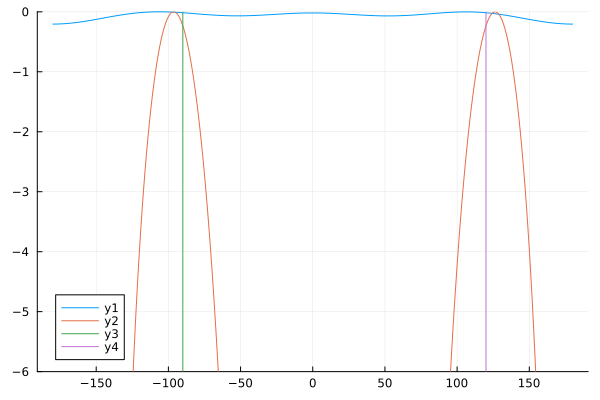

In [230]:
using Plots
dbf_x = abs.(pinv(D) * new_S)
dbfInv_x, az_dbfInv_x = normalize_P(dbf_x.^2, az_list);
P_dbf_norm_x, az_dbf_x = normalize_P(P_dbf, az_list)

plot(az_list, pow2db.(dbfInv_x))
plot!(az_list, pow2db.(P_dbf_norm_x))
plot!([az_gt, az_gt], [-20, 0])
plot!([az_gt2, az_gt2], [-20, 0])
# plot!(az_list, pow2db.(time_x))
ylims!((-6, 0))

In [163]:
using DSP: resample

resample_factor = 24;
resampled_sig = [];
for (ch, sig) in enumerate(eachcol(real_sig))
    push!(resampled_sig, resample( real_sig[:, ch], resample_factor))
end
resampled_sig = transpose(mapreduce(permutedims, vcat, resampled_sig));

In [172]:
size(resampled_sig, 1) / size(real_sig, 1)

23.9999747177873

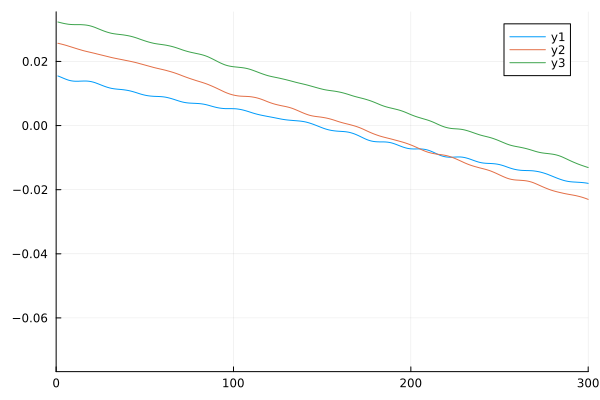

In [162]:
start_idx = resample_factor * 1000;
end_idx = resample_factor * 1100;
plot(resampled_sig[start_idx:end_idx,1])
plot!(resampled_sig[start_idx:end_idx,2])
plot!(resampled_sig[start_idx:end_idx,3])
xlims!(0, 300)

In [30]:
# real_sig, sample_rate = wavread("../signal_generator/50hz_circle.wav");
# real_sig, sample_rate = wavread("../signal_generator/50hz_circle_384kHz.wav");
# real_sig, sample_rate = wavread("../signal_generator/50Hz_0deg_processed.wav");
# real_sig, sample_rate = wavread("../signal_generator/270deg_1kHz_tone_sr32kHz.wav");
real_sig, sample_rate = wavread("../signal_generator/90deg50.wav");

freq = 50;            # Frequency of Interest (in Hz)
c0 = 343;             # Speed of Medium (in m/s)
NFFT = 2^9; #2^11;
noverlap = Int(NFFT * (3 // 4));

function filter_freq_per_ch(new_sig, sample_rate)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate, NFFT, noverlap);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

real_S = filter_freq_per_ch(real_sig, sample_rate);
# resampled_S = filter_freq_per_ch(resampled_sig, resample_factor * sample_rate);

8×3747 Matrix{ComplexF64}:
 -0.180134+0.385415im  -0.309076-0.00856645im  …  -0.537064-0.257821im
 -0.364073+0.988402im  -0.808862+0.00405365im     -0.997471-0.513817im
 -0.341247+1.03423im    -0.85369+0.0528162im       -1.08613-0.525527im
 -0.334255+0.99843im   -0.829364+0.032868im        -1.00697-0.518769im
  -0.14815+0.508343im  -0.432503+0.030234im        -0.47275-0.273134im
  -0.21873+0.547546im  -0.487202-0.0371484im   …  -0.520345-0.282837im
 -0.293646+1.16731im   -0.975351+0.144829im        -1.16259-0.520238im
 -0.121594+0.243835im  -0.348925-0.132432im       -0.436551-0.263421im

In [31]:
size(real_sig)

(480000, 8)

In [32]:
mse = zeros(size(A, 2));
for (idx1, a1) in enumerate(eachcol(A))
    prototype_A = a1;
    x = pinv(prototype_A) * real_S;
    mse[idx1] = norm(real_S - prototype_A * x);
    # end
end

minvalue, indices = findmin(mse);

In [33]:
az_list[indices]

117

In [34]:
function find_sparse_soln(A, y, az_list, n_sparsity=1)
    mse = zeros(size(A, 2));
    for (idx1, a1) in enumerate(eachcol(A))
        prototype_A = a1;
        x = pinv(prototype_A) * y;
        mse[idx1] = norm(y - prototype_A * x);
        # end
    end

    min_error, indices = findmin(mse);
    return az_list[indices[1]], min_error, mse
end

find_sparse_soln (generic function with 2 methods)

In [35]:
function tdoa_sparse(S, corr_samples = 128)
    max_snapshots = div(size(S[1:8,:], 2), corr_samples);
    t_doa = 1:max_snapshots;

    sparse_doas = [];

    @time for t in t_doa
        start = (t-1) * corr_samples + 1;
        end_t = t * corr_samples;
        y = S[1:8, start:end_t]
        # Rx = cov(, dims=2);
        
        az, err, mse = find_sparse_soln(A, y, az_list);
        push!(sparse_doas, az);
    end

    return sparse_doas, t_doa
end

tdoa_sparse (generic function with 2 methods)

In [36]:
sparse_doas, t_doa = tdoa_sparse(real_S)

  1.728805 seconds (75.73 k allocations: 355.517 MiB, 22.11% gc time, 13.84% compilation time)


(Any[-66, -69, 113, 132, 118, 117, 113, 123, 120, 123  …  117, 118, 123, 115, -68, -76, -74, -63, -75, -68], 1:29)

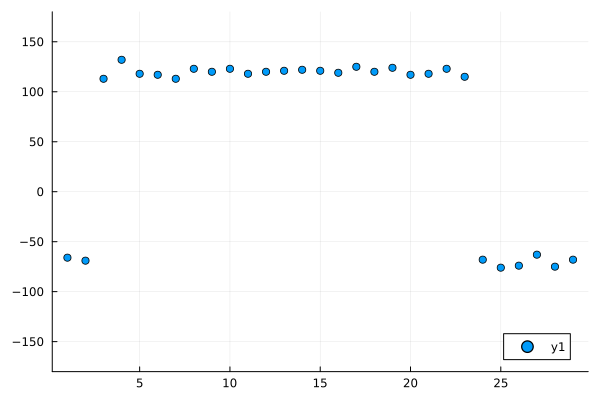

In [37]:
scatter(t_doa, sparse_doas)
ylims!(az_list[1], az_list[end])

In [38]:
sparse_doas

29-element Vector{Any}:
 -66
 -69
 113
 132
 118
 117
 113
 123
 120
 123
   ⋮
 118
 123
 115
 -68
 -76
 -74
 -63
 -75
 -68

In [39]:
Rx = cov(real_S, dims=2)
svd(Rx)

UndefVarError: UndefVarError: cov not defined

In [91]:
using Statistics
mean(real_S, dims=2)

8×1 Matrix{ComplexF64}:
 -0.34663919350345307 + 0.0im
   1.6778229212663904 + 0.0im
   2.7352329925993035 + 0.0im
    3.516335399629507 + 0.0im
    5.914996453442888 + 0.0im
   1.5145013496011062 + 0.0im
   1.8333591688798345 + 0.0im
   1.6075597283314973 + 0.0im